<h2>Updating the existing dataset (Zenodo) into a simpler format</h2>

<h3>Merging all the different classes together for training</h3>

This dataset is publicly published on kaggle under "mmuizfarhan/solardata-preprocessed"

In [ ]:
import os
import shutil
import cv2
import numpy as np
from tqdm import tqdm

base_dir = "D:\D-Drive Documents\LUMS Semester 6\Deep Learning\Project\solardata\DL Dataset"
output_images_dir = "images"
output_masks_dir = "masks"
label_output_dir = "labels"

os.makedirs(output_images_dir, exist_ok=True)
os.makedirs(output_masks_dir, exist_ok=True)
os.makedirs(label_output_dir, exist_ok=True)

def process_directory(root_dir):
    image_label_pairs = []
    
    for category in os.listdir(root_dir):
        category_path = os.path.join(root_dir, category)
        if not os.path.isdir(category_path):
            continue
            
        for subdir in os.listdir(category_path):
            subdir_path = os.path.join(category_path, subdir)
            if not os.path.isdir(subdir_path):
                continue
                
            # Collect all non-label BMP files
            bmp_files = [f for f in os.listdir(subdir_path) 
                        if f.endswith('.bmp') and not f.endswith('_label.bmp')]
            
            for img_file in bmp_files:
                base_name = img_file.replace('.bmp', '')
                label_file = f"{base_name}_label.bmp"
                label_path = os.path.join(subdir_path, label_file)
                
                if os.path.exists(label_path):
                    img_path = os.path.join(subdir_path, img_file)
                    image_label_pairs.append((img_path, label_path))
    
    return image_label_pairs

all_pairs = process_directory(base_dir)


In [ ]:

for idx, (img_path, label_path) in enumerate(tqdm(all_pairs, desc="Organizing files")):
    img_filename = f"img_{idx:05d}.bmp"
    label_filename = f"img_{idx:05d}_label.bmp"
    
    shutil.copy(img_path, os.path.join(output_images_dir, img_filename))
    shutil.copy(label_path, os.path.join(output_masks_dir, label_filename))


Organizing files: 100%|██████████| 3716/3716 [04:30<00:00, 13.75it/s]


In [ ]:
def standardize_mask(mask):
    mask_standard = np.zeros_like(mask)
    mask_standard[mask > 0] = 255  # Any non-zero becomes 255
    return mask_standard
    
for mask_file in tqdm(os.listdir(output_masks_dir), desc="Generating YOLO labels"):
    if not mask_file.endswith(".bmp"):
        continue
        
    mask_path = os.path.join(output_masks_dir, mask_file)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = standardize_mask(mask)
    h, w = mask.shape
    
    _, binary = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    label_lines = []
    for cnt in contours:
        x, y, bw, bh = cv2.boundingRect(cnt)
        if bw < 2 or bh < 2:  # Skip small detections
            continue
            
        x_center = (x + bw/2)/w
        y_center = (y + bh/2)/h
        norm_w = bw/w
        norm_h = bh/h
        
        label_lines.append(f"0 {x_center:.6f} {y_center:.6f} {norm_w:.6f} {norm_h:.6f}")
    
    label_filename = mask_file.replace("_label.bmp", ".txt")
    with open(os.path.join(label_output_dir, label_filename), "w") as f:
        f.write("\n".join(label_lines))

print(f"\nPreprocessing complete! Processed {len(all_pairs)} image-label pairs.")
print(f"Images saved to: {output_images_dir}")
print(f"Masks saved to: {output_masks_dir}")
print(f"YOLO labels saved to: {label_output_dir}")

Generating YOLO labels: 100%|██████████| 3716/3716 [01:04<00:00, 57.87it/s]


Preprocessing complete! Processed 3716 image-label pairs.
Images saved to: /images
Masks saved to: /masks
YOLO labels saved to: /labels


In [ ]:
import os
import shutil

src_folder = 'D:\D-Drive Documents\LUMS Semester 6\Deep Learning\Project\images'
dst_base = 'D:\D-Drive Documents\LUMS Semester 6\Deep Learning\Project'

all_images = sorted(os.listdir(src_folder))
total_images = len(all_images)
split_size = total_images // 4  

for i in range(4):
    folder_name = os.path.join(dst_base, f'folder_{i+1}')
    os.makedirs(folder_name, exist_ok=True)

    start_idx = i * split_size
    end_idx = (i+1) * split_size if i < 3 else total_images  
    for img in all_images[start_idx:end_idx]:
        shutil.move(os.path.join(src_folder, img), os.path.join(folder_name, img))

print("Done splitting!")

Done splitting!


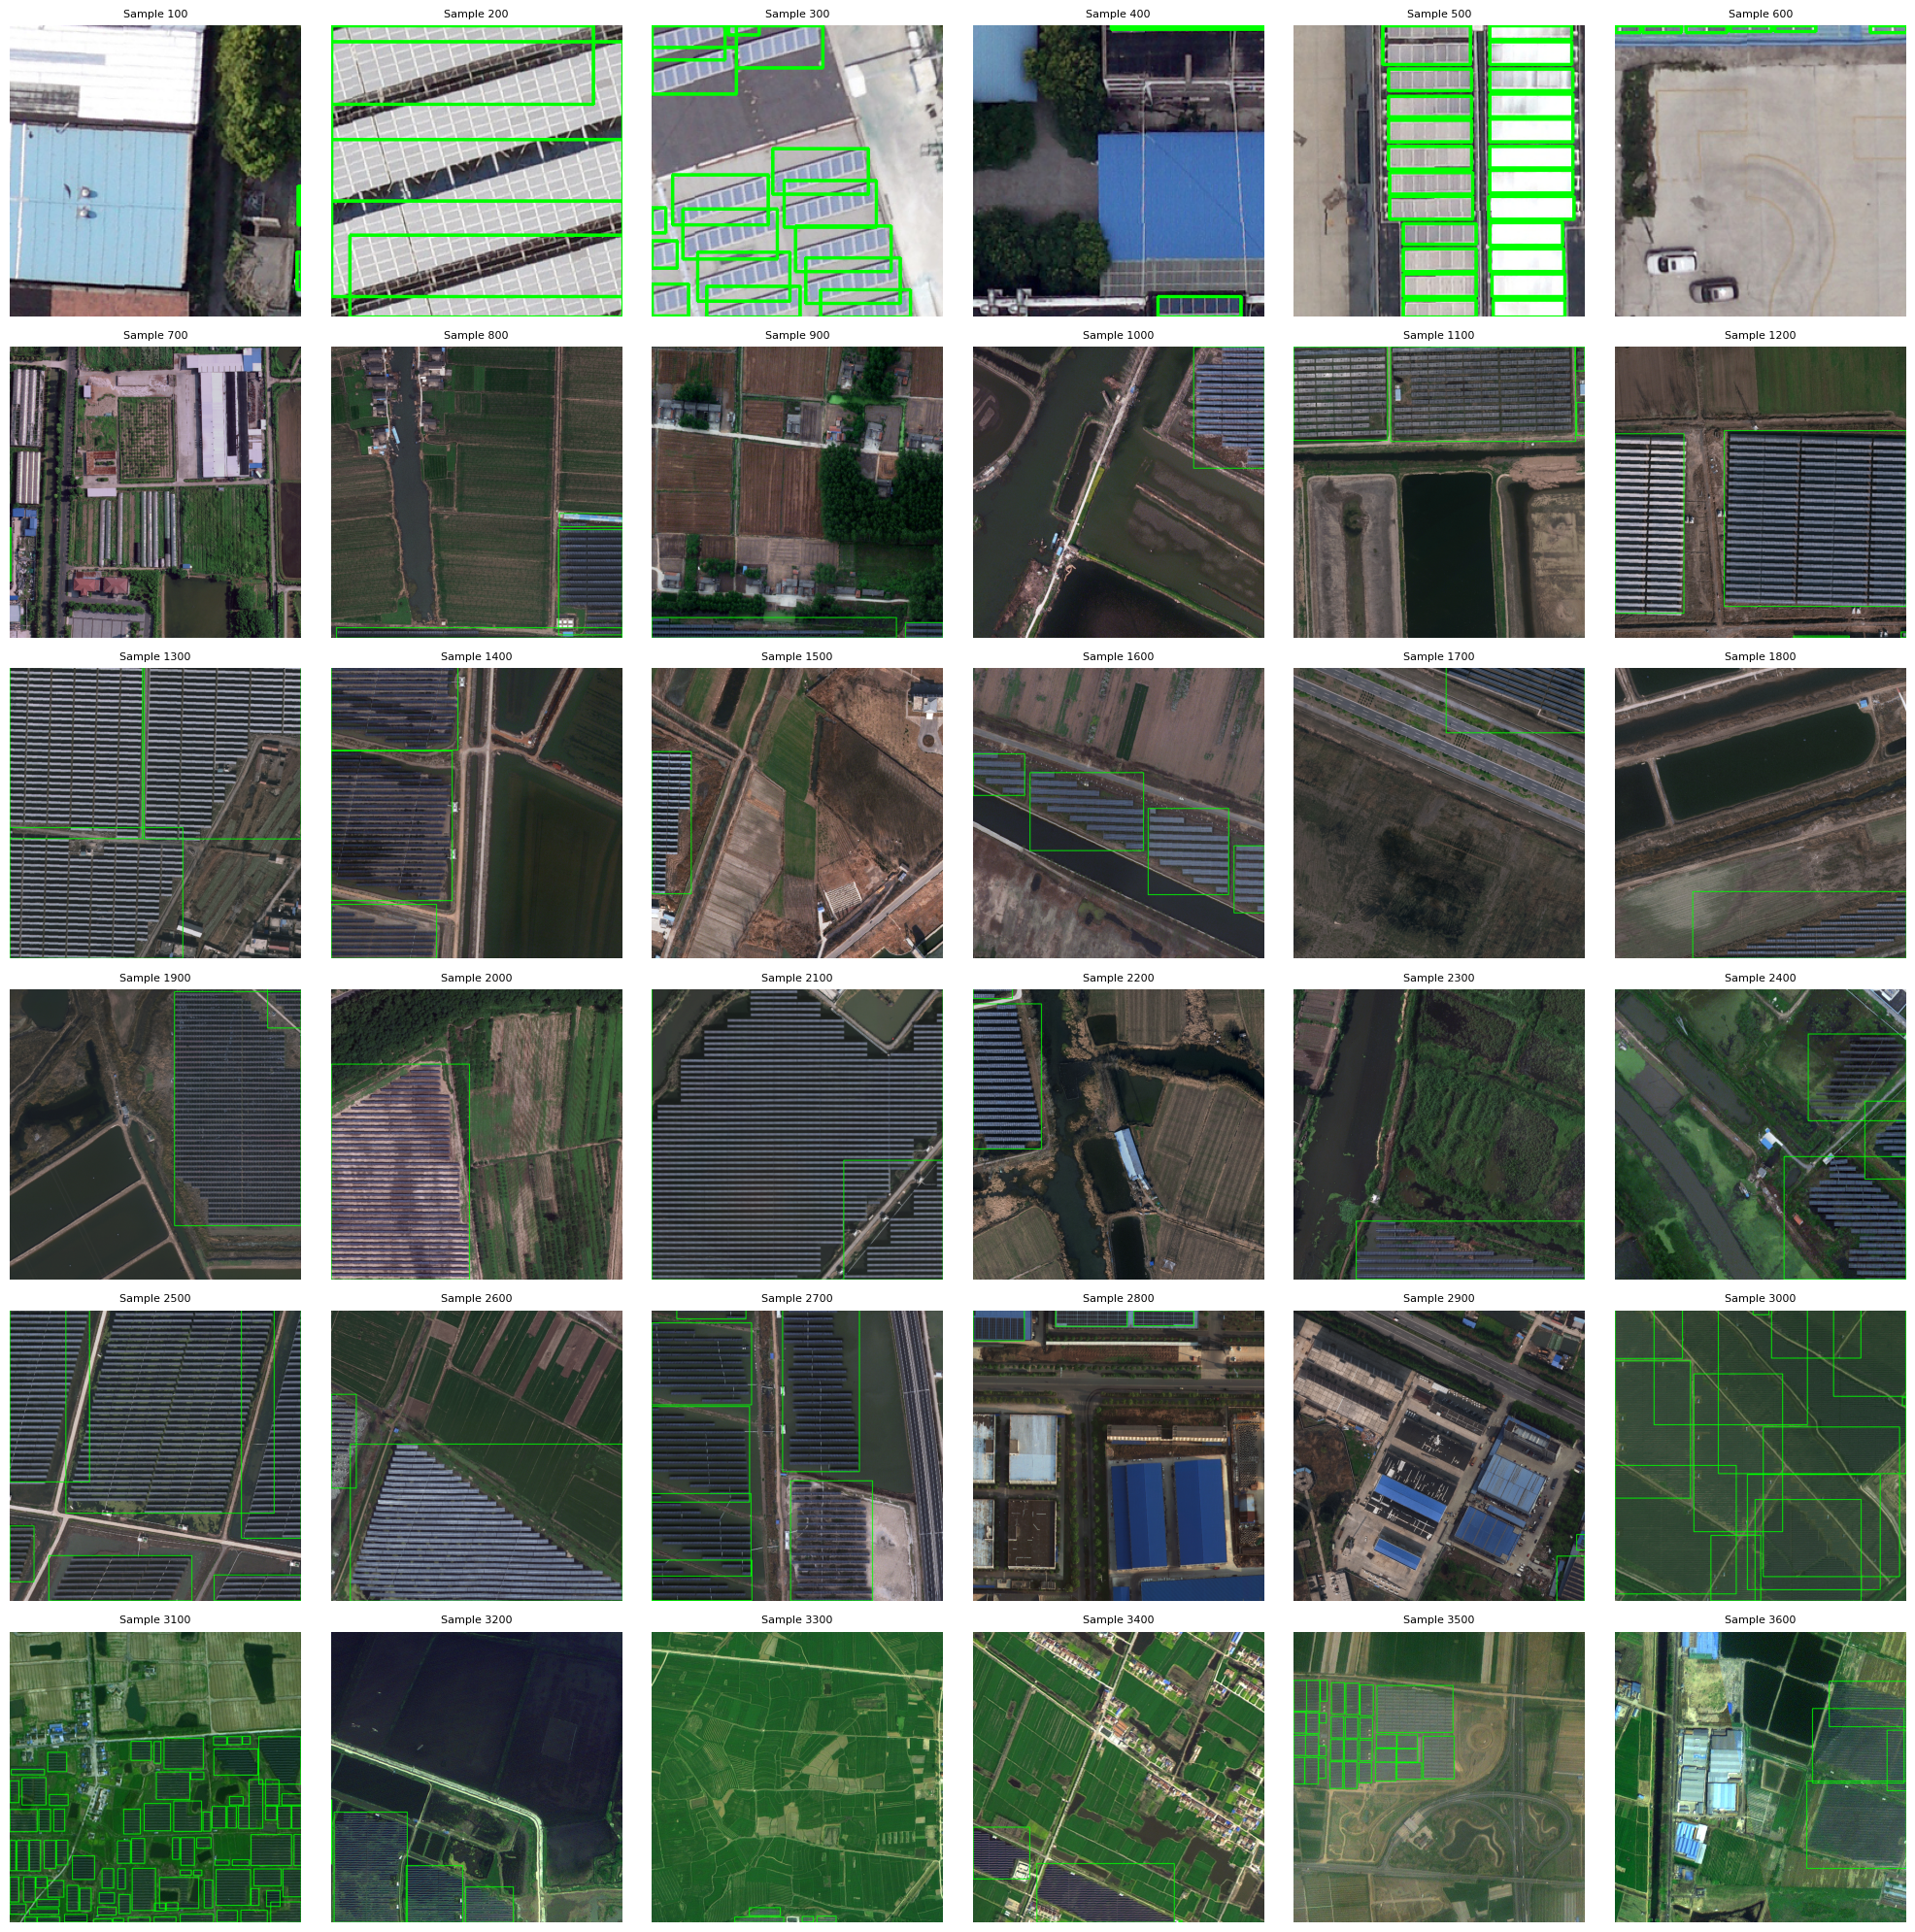

In [ ]:
import matplotlib.pyplot as plt
import os
import cv2
import math

base_dir = "D:\D-Drive Documents\LUMS Semester 6\Deep Learning\Project\solardata\DL Dataset"
output_images_dir = "D:\D-Drive Documents\LUMS Semester 6\Deep Learning\Project\images"
output_masks_dir = "D:\D-Drive Documents\LUMS Semester 6\Deep Learning\Project\masks"
label_output_dir = "D:\D-Drive Documents\LUMS Semester 6\Deep Learning\Project\labels"


def visualize_grid(start_idx=100, end_idx=3700, step=100, cols=6, rows=6):
    total_samples = math.ceil((end_idx - start_idx) / step)
    plt.figure(figsize=(20, 20))
    
    for i in range(total_samples):
        idx = start_idx + i * step
        if idx > end_idx:
            break
            
        img_path = os.path.join(output_images_dir, f"img_{idx:05d}.bmp")
        label_path = os.path.join(label_output_dir, f"img_{idx:05d}.txt")
        
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]
        
        # Draw bounding boxes
        if os.path.exists(label_path):
            with open(label_path) as f:
                for line in f:
                    cls, xc, yc, bw, bh = map(float, line.split())
                    x1 = int((xc - bw/2) * w)
                    y1 = int((yc - bh/2) * h)
                    x2 = int((xc + bw/2) * w)
                    y2 = int((yc + bh/2) * h)
                    cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,0), 2)
        
        plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.title(f"Sample {idx}", fontsize=8)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

for start in range(100, 3700, 36*100):  
    end = min(start + 36*100 - 1, 3700)
    visualize_grid(start, end, 100, cols=6, rows=6)